Author: Bram van Duinen

Date: 13 nov 2023

Content: Random test

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from scipy.ndimage import minimum_filter, maximum_filter

In [2]:
daily = '/net/pc200256/nobackup/users/most/LENTIS/present/day/'
psl = xr.open_dataset(daily + 'psl_d/psl_d_ECEarth3_h010.nc')
tas = xr.open_dataset(daily + 'tas_d/tas_d_ECEarth3_h010.nc')

energy = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
NOR = xr.open_dataset(energy + 'NOR_LENTIS_PD_02_v4.nc')

In [3]:
psl_test = psl.isel(time = 0).isel(bnds = 0)

In [4]:
lons = psl_test.lon.values
lats = psl_test.lat.values

In [5]:
lons

array([-32.34375 , -31.640625, -30.9375  , -30.234375, -29.53125 ,
       -28.828125, -28.125   , -27.421875, -26.71875 , -26.015625,
       -25.3125  , -24.609375, -23.90625 , -23.203125, -22.5     ,
       -21.796875, -21.09375 , -20.390625, -19.6875  , -18.984375,
       -18.28125 , -17.578125, -16.875   , -16.171875, -15.46875 ,
       -14.765625, -14.0625  , -13.359375, -12.65625 , -11.953125,
       -11.25    , -10.546875,  -9.84375 ,  -9.140625,  -8.4375  ,
        -7.734375,  -7.03125 ,  -6.328125,  -5.625   ,  -4.921875,
        -4.21875 ,  -3.515625,  -2.8125  ,  -2.109375,  -1.40625 ,
        -0.703125,   0.      ,   0.703125,   1.40625 ,   2.109375,
         2.8125  ,   3.515625,   4.21875 ,   4.921875,   5.625   ,
         6.328125,   7.03125 ,   7.734375,   8.4375  ,   9.140625,
         9.84375 ,  10.546875,  11.25    ,  11.953125,  12.65625 ,
        13.359375,  14.0625  ,  14.765625,  15.46875 ,  16.171875,
        16.875   ,  17.578125,  18.28125 ,  18.984375,  19.687

In [6]:
#Norway
lat_loc = 59.54
lon_loc = 10.45
ilat_loc = np.where(np.abs(lats - lat_loc) == np.min(np.abs(lats - lat_loc)))[0]
ilon_loc = np.where(np.abs(lons - lon_loc) == np.min(np.abs(lons - lon_loc)))[0]

In [7]:
tas_nor = tas.isel(bnds = 0).isel(lon = ilon_loc).isel(lat = ilat_loc)

Text(0, 0.5, 'tas Oslo [K]')

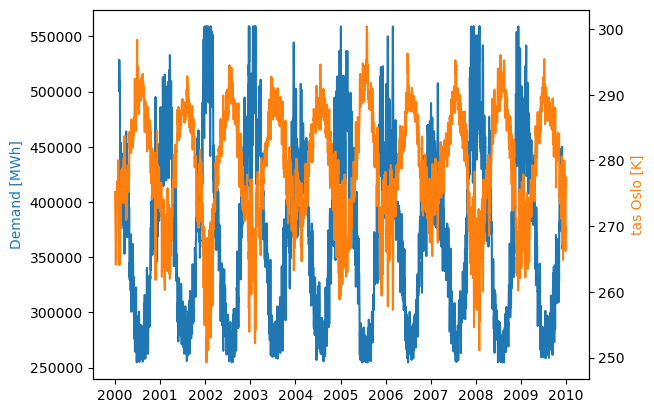

In [8]:
fig, ax1 = plt.subplots()
plt.plot(NOR.sel(runs='h010').time, NOR.sel(runs='h010').demand, label='Demand', color='C0')
ax2 = ax1.twinx()
ax2.plot(tas_nor.time, np.squeeze(tas_nor.tas), label = 'tas', color = 'C1')

# Adding labels and title
ax1.set_ylabel('Demand [MWh]', color = 'C0')
ax2.set_ylabel('tas Oslo [K]', color = 'C1')

Text(0.5, 1.0, '2000-01-01T12:00:00.000000000')

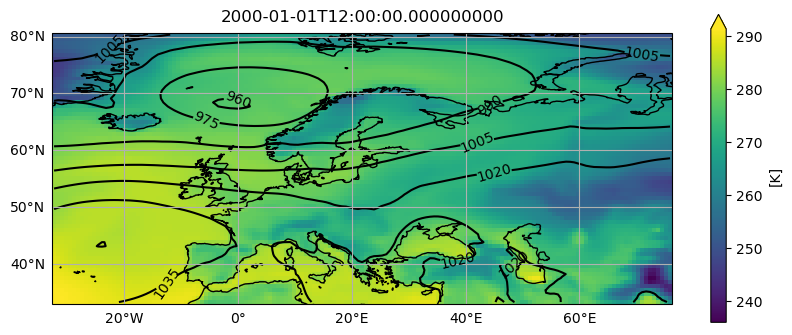

In [9]:
tas_test = tas.isel(bnds = 0).isel(time = 0).tas

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
im1 = ax.pcolormesh(lons, lats, tas_test, shading='nearest') 
CS = ax.contour(lons, lats, psl_test.psl/100, colors='k')
ax.clabel(CS, inline=True, fontsize=10)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
cbar = fig.colorbar(im1, ax=ax, orientation='vertical', shrink=0.4, extend= 'max', label='[K]')
plt.title(str(tas.isel(bnds = 0).time.values[0]))

Doesnt work

IndexError: index 124 is out of bounds for axis 0 with size 68

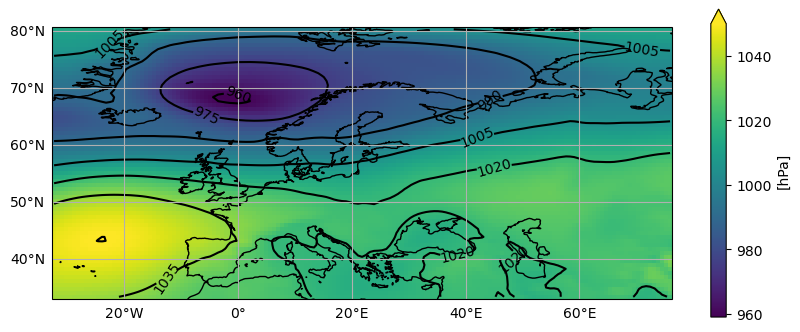

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
im1 = ax.pcolormesh(lons, lats, psl_test.psl/100, shading='nearest') 
CS = ax.contour(lons, lats, psl_test.psl/100, colors='k')
ax.clabel(CS, inline=True, fontsize=10)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
cbar = fig.colorbar(im1, ax=ax, orientation='vertical', shrink=0.4, extend= 'max', label='[hPa]')

#plot H and L for high and low pressure centers, doesnt work yet

def extrema(mat,mode='wrap',window=10):
    """find the indices of local extrema (min and max)
    in the input array."""
    mn = minimum_filter(mat, size=window, mode=mode)
    mx = maximum_filter(mat, size=window, mode=mode)
    # (mat == mx) true if pixel is equal to the local max
    # (mat == mn) true if pixel is equal to the local in
    # Return the indices of the maxima, minima
    return np.nonzero(mat == mn), np.nonzero(mat == mx)

prmsl = psl_test.psl/100

xmin, xmax, ymin, ymax = ax.get_extent()
lons2d, lats2d = np.meshgrid(lons, lats) # lons lats are in degrees
my_proj = ccrs.PlateCarree()
transformed = my_proj.transform_points(ccrs.PlateCarree(), lons2d, lats2d)
x = transformed[..., 0]  # lons in projection coordinates
y = transformed[..., 1]  # lats in projection coordinates

local_min, local_max = extrema(prmsl, mode='wrap', window=50)
xlows = x[local_min]; xhighs = x[local_max]
ylows = y[local_min]; yhighs = y[local_max]
lowvals = prmsl[local_min]; highvals = prmsl[local_max]
# plot lows as blue L's, with min pressure value underneath.
xyplotted = []
# don't plot if there is already a L or H within dmin meters.
yoffset = 0.022*(ymax-ymin)
dmin = yoffset
for x,y,p in zip(xlows, ylows, lowvals):
    if x < xmax and x > xmin and y < ymax and y > ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'L',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='b')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='b',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))

# plot highs as red H's, with max pressure value underneath.
xyplotted = []
for x,y,p in zip(xhighs, yhighs, highvals):
    if x < xmax and x > xmin and y < ymax and y > ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'H',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='r')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='r',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))